# Fortegra Data Challenge 

A new potential partner is coming to us with a potential portfolio for us to work with. The portfolio is insurance for irrigation sprinklers, a type of farming equipment. They have been running this program for about 5 years and are looking for a new partner to work with them. We have an opportunity to analyze their data and recommend underwriting changes to improve the performance of their portfolio. We are targeting a loss rate of 60% or lower for any portfolio we work with. Loss ratio is defined as sum of total claims paid / sum of total premium earned, over a given time period.
There are 2 datasets attached: claims.csv has one row per claim filed and premiums.csv has one row per piece of equipment.
1. Clean the data how you see fit. State your assumptions. Assume that a cleaned subset of the data is better than data which is skewed, biased, or incorrect. Include conceptual validations/cleaning.
2. Calculate loss ratio by state, county, customer’s number of previous claims, deductible amount, and equipment year. Explain your results and note anything you found interesting or important.
3. Perform other pieces of EDA/analysis you think is interesting. Since time is limited, you can limit to 1-2 analyses, then list other analysis you think would be interesting to look at if you had more time.
4. Based on the analysis you’ve done, what are some recommended changes to the underwriting of this portfolio?


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
claims_data = '../data/claims.csv'
premiums_data = '../data/premiums.csv'

In [4]:
claims_df = pd.read_csv(claims_data)
premiums_df = pd.read_csv(premiums_data)

# Data Sanity Checks
## Claims Dataframe

#### Check for null or NaN values

In [5]:
claims_df.isna().sum()

PolicyNumber            0
CustomerId              0
DateOfLoss              0
ClaimReceivedDate       2
ClaimCause              0
TotalPaidToDate         0
Deductible              0
County                 31
State                  31
EquipmentYear          33
PolicyEffectiveDate     0
dtype: int64

In [6]:
claims_df[claims_df.isna().any(axis = 1)].head(10)

,PolicyNumber,CustomerId,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate,Deductible,County,State,EquipmentYear,PolicyEffectiveDate
44,P-4875-2022,4254,2022-09-05,2022-10-17,Claim Denied,626.50,2500,NaN,NaN,NaN,2022-05-02
140,P-1206-2022,4706,2022-07-05,2022-07-07,Claim Denied,0.00,2500,NaN,NaN,NaN,2022-07-05
335,P-538-2022,3691,2022-05-05,2022-05-09,Claim Withdrawn,0.00,1000,NaN,NaN,NaN,2021-06-01
408,P-2668-2022,2170,2022-04-22,2022-05-11,Claim Denied,0.00,1000,NaN,NaN,NaN,2021-07-30
441,P-4732-2022,510,2022-02-23,2022-05-18,Claim Denied,0.00,1000,NaN,NaN,NaN,2022-02-23
592,P-38-2021,2340,2021-08-19,2021-12-10,Collision-Irr,19224.88,2500,NaN,NaN,NaN,2021-05-15
756,P-5308-2021,967,2021-06-11,2021-06-21,Collision-Irr,50000.00,2500,NaN,NaN,NaN,2020-08-07
813,P-5057-2021,5192,2021-04-01,2021-04-15,Claim Denied,0.00,1000,NaN,NaN,NaN,2020-07-22
827,P-2486-2021,4191,2021-03-15,2021-03-18,Claim Withdrawn,0.00,5000,NaN,NaN,NaN,2020-04-01
843,P-3871-2021,4499,2021-02-22,2021-03-10,Claim Withdrawn,0.00,1000,NaN,NaN,NaN,2021-02-03


#### - It appears that missing information may be linked to "Claim Withdrawn" and "Claim Denied" status in the ClaimCause field.
#### - Additionally, County, State, and EquipmentYear appear to usually be missing concurrently.
#### - The ClaimRecievedDate is missing twice; this may be due to some clerical error.

### Explore Unique Values

In [7]:
claims_df.nunique()

PolicyNumber           2056
CustomerId             1555
DateOfLoss              931
ClaimReceivedDate       831
ClaimCause               16
TotalPaidToDate        2186
Deductible                5
County                  249
State                    20
EquipmentYear            55
PolicyEffectiveDate    1082
dtype: int64

#### - PolicyNumber count is greater than the number of Customers. This is likely due to customers having multiple policies.
#### - This observation holds true for the premiums dataframe as well.

### Feature Breakdown

#### Low-Cardinality Ordinal
1. EquipmentYear
2. Deductible

#### High-Cardinality Ordinal
1. PolicyEffectiveDate
2. ClaimReceivedDate
3. DateOfLoss

#### Low-Cardinality Categorical
1. State
2. ClaimCause

#### High-Cardinality Categorical
1. County
2. CustomerId
3. PolicyNumber

#### Continuous
1. TotalPaidToDate

# Data Sanity Checks
## Premiums Dataframe

#### Check for null or NaN values

In [8]:
premiums_df.isna().sum()

PolicyNumber             0
CustomerId               0
Loc                      0
PolicyEffectiveDate      0
PolicyExpirationDate     0
PolicyPremium            0
LocationPremium          0
Deductible               0
LocValue                 0
County                   0
State                    0
Equip Year              83
Equip Value             83
dtype: int64

In [9]:
premiums_df[premiums_df.isna().any(axis = 1)].head(10)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
5359,P-1031-2022,1278,5,2022-06-01,2023-06-01,40634,2209.107960,1000,163935.90,Edwards,KS,NaN,NaN
5378,P-1031-2022,1278,14,2022-06-01,2023-06-01,40634,2309.700103,1000,147693.00,Edwards,KS,NaN,NaN
8622,P-1860-2019,4671,2,2019-05-06,2020-05-06,2248,358.949932,1000,22954.25,Crosby,TX,NaN,NaN
8624,P-1860-2019,4671,3,2019-05-06,2020-05-06,2248,154.125395,1000,9869.25,Hale,TX,NaN,NaN
8627,P-1860-2020,4671,2,2020-05-06,2021-05-06,2248,367.000000,1000,22954.25,Crosby,TX,NaN,NaN
8629,P-1860-2020,4671,3,2020-05-06,2021-05-06,2248,158.000000,1000,9869.25,Hale,TX,NaN,NaN
9279,P-1042-2018,3246,5,2018-03-26,2019-03-26,5392,557.000000,1000,33743.59,Clay,SD,NaN,NaN
14549,P-3697-2018,1589,6,2018-09-02,2019-09-02,8737,1285.000000,1000,80341.18,Tom Green,TX,NaN,NaN
14558,P-3697-2019,1589,6,2019-09-02,2020-09-02,12615,1380.067683,1000,80341.18,Tom Green,TX,NaN,NaN
14570,P-3697-2020,1589,6,2020-09-02,2021-09-02,12615,1285.000000,1000,80341.18,Tom Green,TX,NaN,NaN


#### - Equipment Year and Equipment Value are typically missing, concurrently.

### Explore Unique Values

In [10]:
premiums_df.nunique()

PolicyNumber            17522
CustomerId               5307
Loc                       126
PolicyEffectiveDate      1995
PolicyExpirationDate     1995
PolicyPremium            6318
LocationPremium         25934
Deductible                  5
LocValue                 3944
County                    383
State                      28
Equip Year                 63
Equip Value              3915
dtype: int64

#### - While it appears that LocValue and Equip Value are the same, LocValue has more distinct values, suggesting there are some differences.

### Feature Breakdown

#### Low-Cardinality Ordinal
1. Equip Year
2. Deductible
3. Loc

#### High-Cardinality Ordinal
1. PolicyExpirationDate
2. PolicyEffectiveDate

#### Low-Cardinality Categorical
1. State

#### High-Cardinality Categorical
1. County
2. CustomerId
3. PolicyNumber

#### Continuous
1. Equip Value
2. LocValue
3. LocationPremium
4. PolicyPremium

# Hypothesis:
### Claim Denied and Claim Withdrawn are linked to NULL values in County/State/Equipment Year

In [11]:
def set_hypothesis_value(
    row : any
) -> int:
    if row['ClaimCause'] == 'Claim Withdrawn' or row['ClaimCause'] == 'Claim Denied':
        return 1
    else:
        return 0

In [12]:
hypothesis_df = claims_df.copy()[['ClaimCause', 'County', 'State', 'EquipmentYear']]
hypothesis_df['hypothesisFlag'] = hypothesis_df.apply(set_hypothesis_value, axis = 1)

In [13]:
hypothesis_df.loc[hypothesis_df['hypothesisFlag'] == 1].head(5)

,ClaimCause,County,State,EquipmentYear,hypothesisFlag
2,Claim Withdrawn,Edwards,KS,0.0,1
6,Claim Denied,Sherman,KS,2001.0,1
15,Claim Withdrawn,Fillmore,NE,1976.0,1
44,Claim Denied,NaN,NaN,NaN,1
64,Claim Withdrawn,Garden,NE,2000.0,1


In [14]:
def set_null_value(
    row : any
) -> int:
    if pd.isna(row['County']) or pd.isna(row['State']) or pd.isna(row['EquipmentYear']):
        return 1
    else:
        return 0

In [15]:
hypothesis_df['nullFlag'] = hypothesis_df.apply(set_null_value, axis = 1)

In [16]:
hypothesis_df.loc[hypothesis_df['hypothesisFlag'] == 1].head(5)

,ClaimCause,County,State,EquipmentYear,hypothesisFlag,nullFlag
2,Claim Withdrawn,Edwards,KS,0.0,1,0
6,Claim Denied,Sherman,KS,2001.0,1,0
15,Claim Withdrawn,Fillmore,NE,1976.0,1,0
44,Claim Denied,NaN,NaN,NaN,1,1
64,Claim Withdrawn,Garden,NE,2000.0,1,0


In [17]:
from scipy.stats import chi2_contingency

In [18]:
contingency_table = pd.crosstab(hypothesis_df['nullFlag'], hypothesis_df['hypothesisFlag'])

chi2, p_value, _, _ = chi2_contingency(contingency_table)

alpha = 0.05
if p_value < alpha:
    print(fr'The binary features are correlated with a p-value of: {p_value}')
else:
    print(fr'The binary features are NOT correlated with a p-value of: {p_value}')

The binary features are correlated with a p-value of: 1.250353815000371e-44


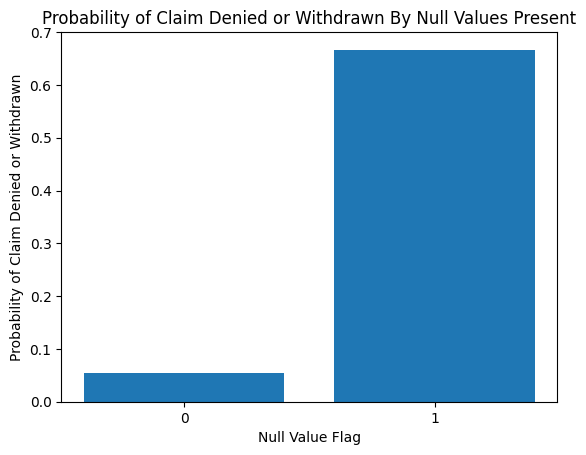

In [19]:
mean_by_nullFlag = hypothesis_df.groupby('nullFlag')['hypothesisFlag'].mean()

plt.bar(mean_by_nullFlag.index.astype(str), mean_by_nullFlag)
plt.xlabel('Null Value Flag')
plt.ylabel('Probability of Claim Denied or Withdrawn')
plt.title('Probability of Claim Denied or Withdrawn By Null Values Present')
plt.show()

### - The hypothesis is true: if a NULL value is present, the claim is MUCH more likely to be denied or withdrawn.
### - Based on the objective of the overall analysis, we can probably drop claims denied and claims withdrawn from the dataset. As a result, this should mostly reduce all of the NULL values.

# Dropping 'Claims Denied' and 'Claims Withdrawn'

In [20]:
claims_df['ClaimCause'].unique()

array(['Lightning-Irr', 'Claim Withdrawn', 'Collision-Irr', 'M&E-Irr',
       'Claim Denied', 'Wind-Irr', 'Collapse-Irr', 'Fire-Irr', 'Hail-Irr',
       'Theft-Irr', 'Flood-Irr', 'Vandalism-Irr', 'Animal-Irr',
       'Overturn-Irr', 'Freezing-Irr', 'Vand-Irr'], dtype=object)

In [21]:
claims_df = claims_df[~claims_df['ClaimCause'].isin(['Claim Denied', 'Claim Withdrawn'])]

### Check for presence of NULL values again

In [22]:
claims_df.isna().sum()

PolicyNumber            0
CustomerId              0
DateOfLoss              0
ClaimReceivedDate       2
ClaimCause              0
TotalPaidToDate         0
Deductible              0
County                  9
State                   9
EquipmentYear          11
PolicyEffectiveDate     0
dtype: int64

#### - Some NULL values are still present; however, NULL values may be important from a modeling perspective.
#### - Nevertheless, for the sake of Exploratory Data Analysis (EDA), we will drop NULL values.
#### - When doing modeling, we will retain NULL values (XGBoost or imputation techniques)

# Dropping NULL Values

In [23]:
claims_df = claims_df.dropna()
claims_df.isna().sum()

PolicyNumber           0
CustomerId             0
DateOfLoss             0
ClaimReceivedDate      0
ClaimCause             0
TotalPaidToDate        0
Deductible             0
County                 0
State                  0
EquipmentYear          0
PolicyEffectiveDate    0
dtype: int64

In [24]:
claims_df.head(5)

,PolicyNumber,CustomerId,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate,Deductible,County,State,EquipmentYear,PolicyEffectiveDate
0,P-654-2022,419,2022-12-23,2023-01-03,Lightning-Irr,10466.75,1000,Chase,NE,1993.0,2022-11-20
1,P-3199-2022,2667,2022-12-19,2023-02-08,Lightning-Irr,4535.69,1000,Tattnall,GA,0.0,2022-03-19
3,P-4890-2022,2794,2022-12-02,2022-12-08,Collision-Irr,20347.48,1000,Pawnee,KS,2022.0,2022-10-01
4,P-4102-2022,1233,2022-11-22,2022-11-29,Collision-Irr,15458.86,1000,Floyd,TX,0.0,2022-04-08
5,P-3968-2022,3700,2022-11-04,2022-11-14,M&E-Irr,8511.76,1000,Cochran,TX,2016.0,2022-02-23


In [25]:
premiums_df = premiums_df.dropna()
premiums_df.isna().sum()

PolicyNumber            0
CustomerId              0
Loc                     0
PolicyEffectiveDate     0
PolicyExpirationDate    0
PolicyPremium           0
LocationPremium         0
Deductible              0
LocValue                0
County                  0
State                   0
Equip Year              0
Equip Value             0
dtype: int64

In [26]:
premiums_df.head(5)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
0,P-562-2018,3833,1,2018-03-01,2019-03-01,594,594.0,1000,36000.0,Furnas,NE,1994.0,36000.0
1,P-5085-2018,3123,1,2018-08-10,2019-08-10,7520,960.0,1000,60000.0,Castro,TX,1993.0,60000.0
2,P-5085-2018,3123,2,2018-08-10,2019-08-10,7520,1760.0,1000,110000.0,Castro,TX,2015.0,110000.0
3,P-5085-2018,3123,3,2018-08-10,2019-08-10,7520,960.0,1000,60000.0,Castro,TX,1988.0,60000.0
4,P-5085-2018,3123,4,2018-08-10,2019-08-10,7520,1760.0,1000,110000.0,Castro,TX,2014.0,110000.0


# Combining Premium and Claim Information

In [27]:
claim_specific_df = claims_df.copy()[['PolicyNumber', 'DateOfLoss', 'ClaimReceivedDate', 'ClaimCause', 'TotalPaidToDate']]

### Check PolicyNumber data type in both fields before merging

In [28]:
premiums_df['PolicyNumber'] = premiums_df['PolicyNumber'].astype(str)
claim_specific_df['PolicyNumber'] = claim_specific_df['PolicyNumber'].astype(str)

In [29]:
claims_premiums_df = pd.merge(premiums_df, claim_specific_df, on = 'PolicyNumber', how = 'left')

In [30]:
claims_premiums_df.notna().sum()

PolicyNumber            86567
CustomerId              86567
Loc                     86567
PolicyEffectiveDate     86567
PolicyExpirationDate    86567
PolicyPremium           86567
LocationPremium         86567
Deductible              86567
LocValue                86567
County                  86567
State                   86567
Equip Year              86567
Equip Value             86567
DateOfLoss              19771
ClaimReceivedDate       19771
ClaimCause              19771
TotalPaidToDate         19771
dtype: int64

In [31]:
claims_premiums_df.head(10)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate
0,P-562-2018,3833,1,2018-03-01,2019-03-01,594,594.0,1000,36000.0,Furnas,NE,1994.0,36000.0,NaN,NaN,NaN,NaN
1,P-5085-2018,3123,1,2018-08-10,2019-08-10,7520,960.0,1000,60000.0,Castro,TX,1993.0,60000.0,NaN,NaN,NaN,NaN
2,P-5085-2018,3123,2,2018-08-10,2019-08-10,7520,1760.0,1000,110000.0,Castro,TX,2015.0,110000.0,NaN,NaN,NaN,NaN
3,P-5085-2018,3123,3,2018-08-10,2019-08-10,7520,960.0,1000,60000.0,Castro,TX,1988.0,60000.0,NaN,NaN,NaN,NaN
4,P-5085-2018,3123,4,2018-08-10,2019-08-10,7520,1760.0,1000,110000.0,Castro,TX,2014.0,110000.0,NaN,NaN,NaN,NaN
5,P-5085-2018,3123,5,2018-08-10,2019-08-10,7520,1040.0,1000,65000.0,Castro,TX,2007.0,65000.0,NaN,NaN,NaN,NaN
6,P-5085-2018,3123,6,2018-08-10,2019-08-10,7520,1040.0,1000,65000.0,Castro,TX,2007.0,65000.0,NaN,NaN,NaN,NaN
7,P-5085-2019,3123,1,2019-08-10,2020-08-10,7520,960.0,1000,60000.0,Castro,TX,1993.0,60000.0,2019-03-13,2019-04-08,Wind-Irr,11266.51
8,P-5085-2019,3123,2,2019-08-10,2020-08-10,7520,1760.0,1000,110000.0,Castro,TX,2015.0,110000.0,2019-03-13,2019-04-08,Wind-Irr,11266.51
9,P-5085-2019,3123,3,2019-08-10,2020-08-10,7520,960.0,1000,60000.0,Castro,TX,1988.0,60000.0,2019-03-13,2019-04-08,Wind-Irr,11266.51


# Drop LocValue because it is the same as Equip Value

In [32]:
claims_premiums_df.drop(['LocValue'], axis = 1, inplace = True)

# Univariate Analysis

### Continuous Features: PolicyPremium, LocationPremium, Equip Value, TotalPaidToDate

#### PolicyPremium

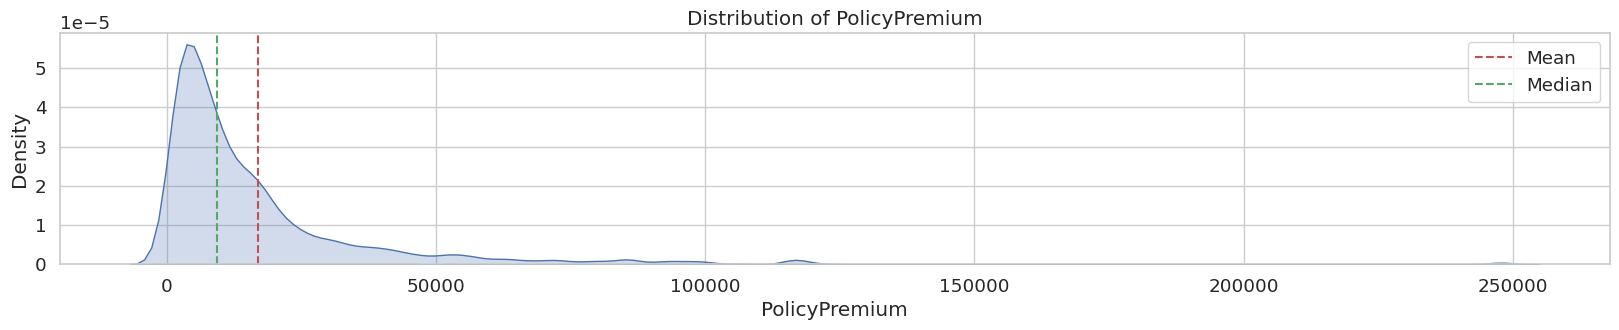

In [33]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
sns.kdeplot(data = claims_premiums_df['PolicyPremium'], color = 'b', fill = True)

plt.xlabel('PolicyPremium')
plt.ylabel('Density')
plt.title('Distribution of PolicyPremium')

mean = claims_premiums_df['PolicyPremium'].mean()
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.legend()

median = claims_premiums_df['PolicyPremium'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

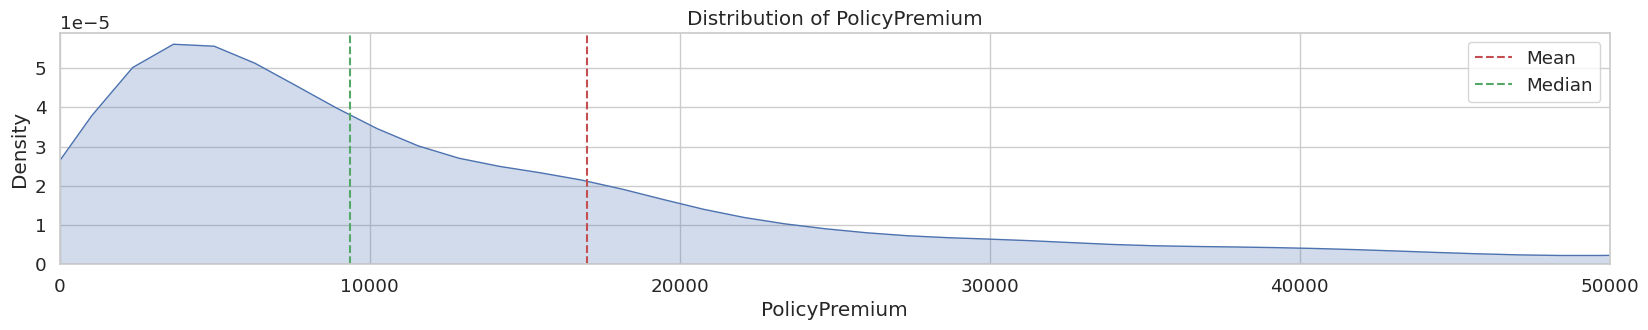

In [34]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
ax = sns.kdeplot(data = claims_premiums_df['PolicyPremium'], color = 'b', fill = True)

ax.set_xlim([0, 50000])

plt.xlabel('PolicyPremium')
plt.ylabel('Density')
plt.title('Distribution of PolicyPremium')

mean = claims_premiums_df['PolicyPremium'].mean()
plt.axvline(mean, color = 'r', linestyle = '--', label = 'Mean')
plt.legend()

median = claims_premiums_df['PolicyPremium'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

#### **Discussion**: The PolicyPremium field is a right-skewed (positive skew) distribution. The peak of the distribution is nested somewhere around $4000.

### LocationPremium

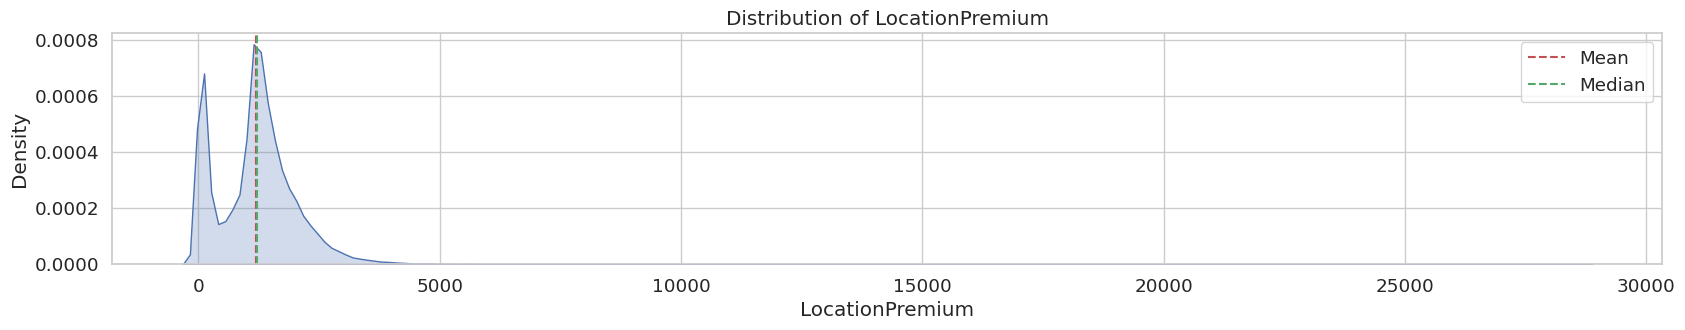

In [35]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
sns.kdeplot(data = claims_premiums_df['LocationPremium'], color = 'b', fill = True)

plt.xlabel('LocationPremium')
plt.ylabel('Density')
plt.title('Distribution of LocationPremium')

mean = claims_premiums_df['LocationPremium'].mean()
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.legend()

median = claims_premiums_df['LocationPremium'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

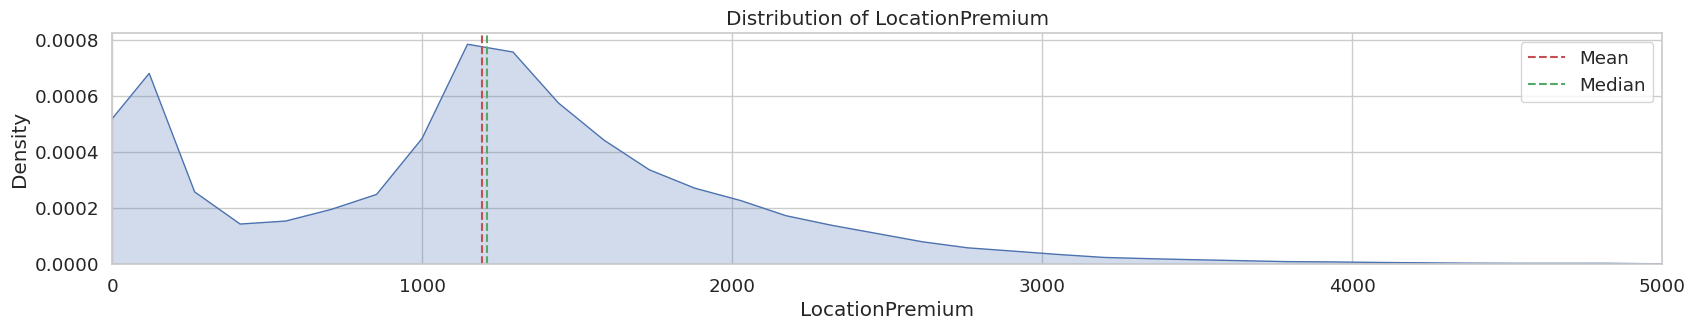

In [37]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
ax = sns.kdeplot(data = claims_premiums_df['LocationPremium'], color = 'b', fill = True)

ax.set_xlim([0, 5000])

plt.xlabel('LocationPremium')
plt.ylabel('Density')
plt.title('Distribution of LocationPremium')

mean = claims_premiums_df['LocationPremium'].mean()
plt.axvline(mean, color = 'r', linestyle = '--', label = 'Mean')
plt.legend()

median = claims_premiums_df['LocationPremium'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

#### **Discussion**: LocationPremium is a bi-modal distribution. This may require additional feature engineering. It is also right-skewed.
#### One peak of the distribution appear to be around \$1,000.
#### The other peak is $12,000.

### Equip Value

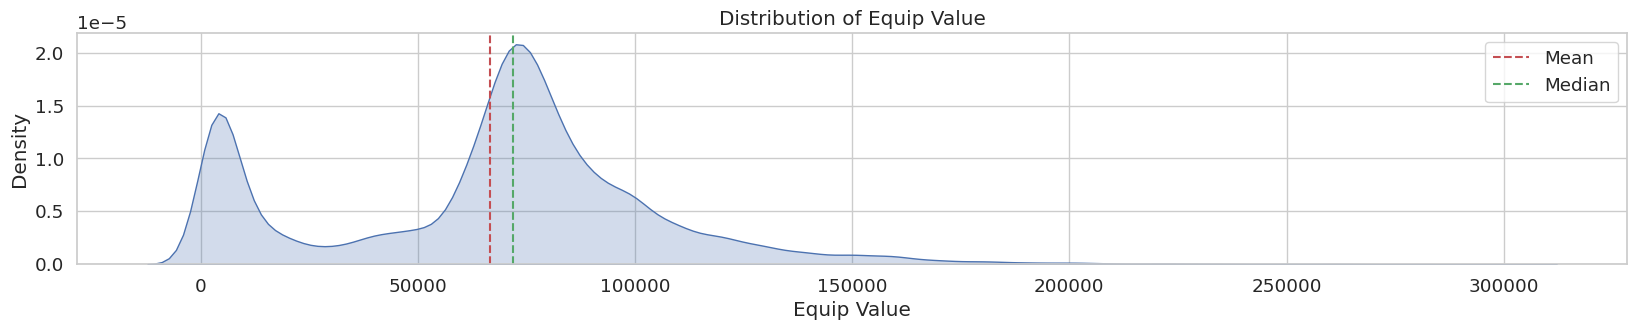

In [38]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
sns.kdeplot(data = claims_premiums_df['Equip Value'], color = 'b', fill = True)

plt.xlabel('Equip Value')
plt.ylabel('Density')
plt.title('Distribution of Equip Value')

mean = claims_premiums_df['Equip Value'].mean()
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.legend()

median = claims_premiums_df['Equip Value'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

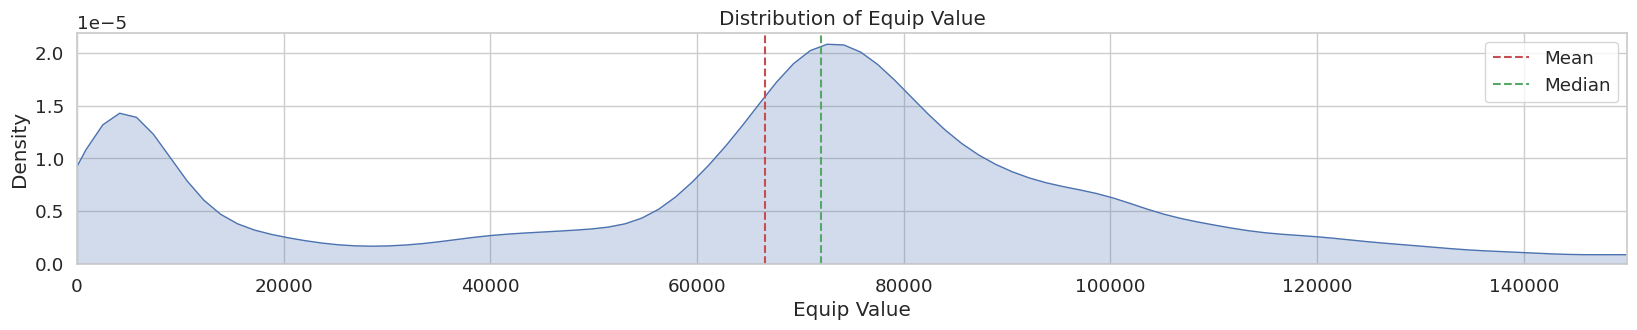

In [40]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
ax = sns.kdeplot(data = claims_premiums_df['Equip Value'], color = 'b', fill = True)

ax.set_xlim([0, 150000])

plt.xlabel('Equip Value')
plt.ylabel('Density')
plt.title('Distribution of Equip Value')

mean = claims_premiums_df['Equip Value'].mean()
plt.axvline(mean, color = 'r', linestyle = '--', label = 'Mean')
plt.legend()

median = claims_premiums_df['Equip Value'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

#### **Discussion**: Equip Value is another bi-modal distribution with right-skewness.
#### The first peak appears to be at \$4,000.
#### The other peak appears to be at \$75,000.

### TotalPaidToDate

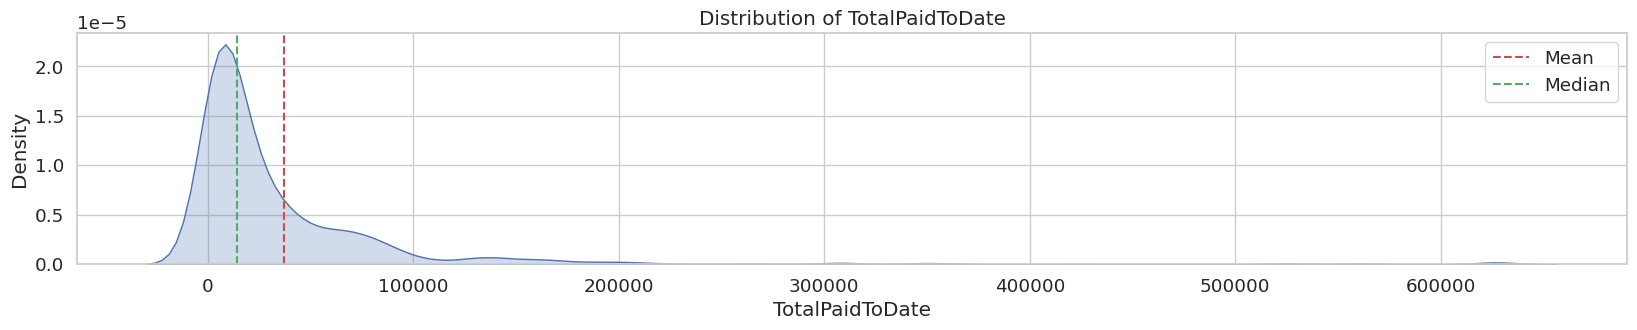

In [41]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
sns.kdeplot(data = claims_premiums_df['TotalPaidToDate'], color = 'b', fill = True)

plt.xlabel('TotalPaidToDate')
plt.ylabel('Density')
plt.title('Distribution of TotalPaidToDate')

mean = claims_premiums_df['TotalPaidToDate'].mean()
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.legend()

median = claims_premiums_df['TotalPaidToDate'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

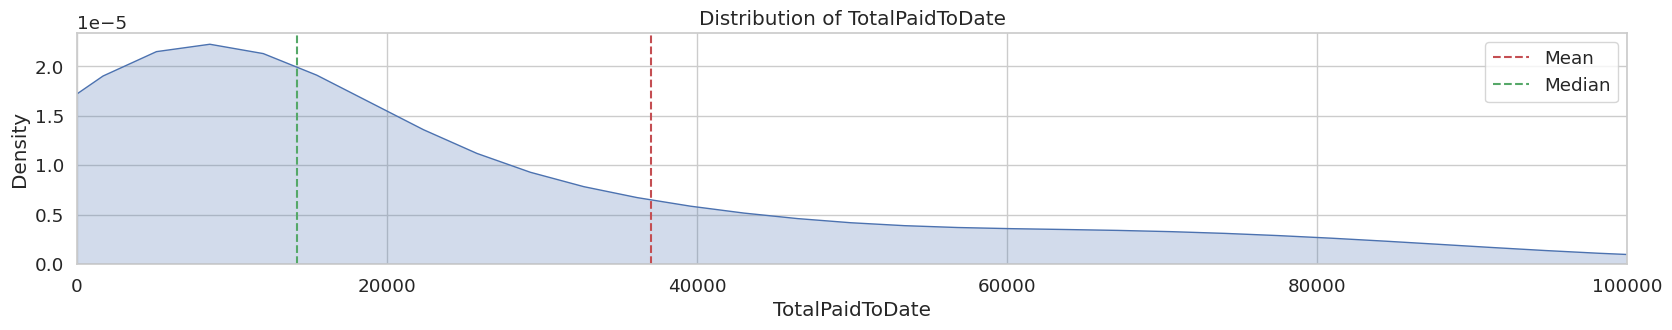

In [43]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
ax = sns.kdeplot(data = claims_premiums_df['TotalPaidToDate'], color = 'b', fill = True)

ax.set_xlim([0, 100000])

plt.xlabel('TotalPaidToDate')
plt.ylabel('Density')
plt.title('Distribution of TotalPaidToDate')

mean = claims_premiums_df['TotalPaidToDate'].mean()
plt.axvline(mean, color = 'r', linestyle = '--', label = 'Mean')
plt.legend()

median = claims_premiums_df['TotalPaidToDate'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

#### **Discussion**: The TotalPaidToDate feature is right-skewed. The peak of the distribution appears to be at \$9,000.

## Low-Cardinality Ordinal Features: Equip Year, Deductible

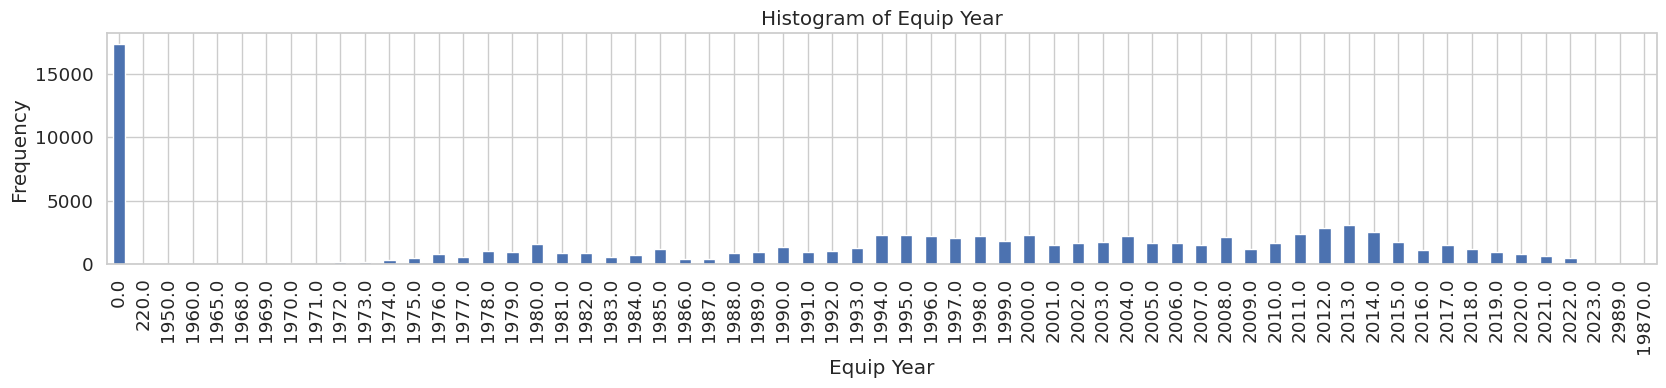

In [46]:
value_counts = claims_premiums_df['Equip Year'].value_counts().sort_index()

plt.figure(figsize = (20, 3))
value_counts.plot(kind='bar')
plt.xlabel('Equip Year')
plt.ylabel('Frequency')
plt.title('Histogram of Equip Year')
plt.show()

In [48]:
claims_premiums_df.loc[claims_premiums_df['Equip Year'] == 0.0].head(2)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,County,State,Equip Year,Equip Value,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate
174,P-1195-2020,3222,2,2020-05-29,2021-05-29,5016,143.152835,1000,Fillmore,NE,0.0,5000.0,NaN,NaN,NaN,NaN
175,P-1195-2020,3222,2,2020-05-29,2021-05-29,5016,431.342095,1000,Fillmore,NE,0.0,15000.0,NaN,NaN,NaN,NaN


In [49]:
claims_premiums_df.loc[claims_premiums_df['Equip Year'] == 220.0].head(2)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,County,State,Equip Year,Equip Value,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate
10054,P-4604-2019,4916,41,2019-12-06,2020-12-06,45152,0.000000,1000,Hamilton,NE,220.0,66000.0,2019-06-05,2019-06-10,Lightning-Irr,14692.22
75862,P-3065-2019,1784,5,2019-05-18,2020-05-18,4881,357.649601,1000,Bent,CO,220.0,110000.0,NaN,NaN,NaN,NaN


In [50]:
claims_premiums_df.loc[claims_premiums_df['Equip Year'] == 2989.0].head(2)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,County,State,Equip Year,Equip Value,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate
20919,P-2669-2018,3023,1,2018-09-23,2019-09-23,1188,1188.0,1000,Clay,NE,2989.0,72000.0,NaN,NaN,NaN,NaN
20920,P-2669-2019,3023,1,2019-09-23,2020-09-23,1188,1188.0,1000,Clay,NE,2989.0,72000.0,NaN,NaN,NaN,NaN


In [52]:
claims_premiums_df.loc[claims_premiums_df['Equip Year'] == 19870.0].head(2)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,County,State,Equip Year,Equip Value,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate
84612,P-3664-2017,1165,15,2017-09-08,2018-09-08,32960,2080.0,1000,Dallam,TX,19870.0,130000.0,NaN,NaN,NaN,NaN


#### **Discussion**: Based on this analysis of Equip Year, it can be assumed that values of 0.0 represent NULL.
#### Additionally, outlandish values should be imputed to be 0.0.
#### **Proposition**: Any values outside the range of 1950 - PRESENT should be imputed to 0.0.

In [53]:
from datetime import datetime

def impute_zero_for_year(
    value : float
) -> float:
    current_year = datetime.now().year
    if 1950.0 <= value <= current_year:
        return value
    else:
        return 0.0

In [54]:
claims_premiums_df['Equip Year'] = claims_premiums_df['Equip Year'].apply(impute_zero_for_year)

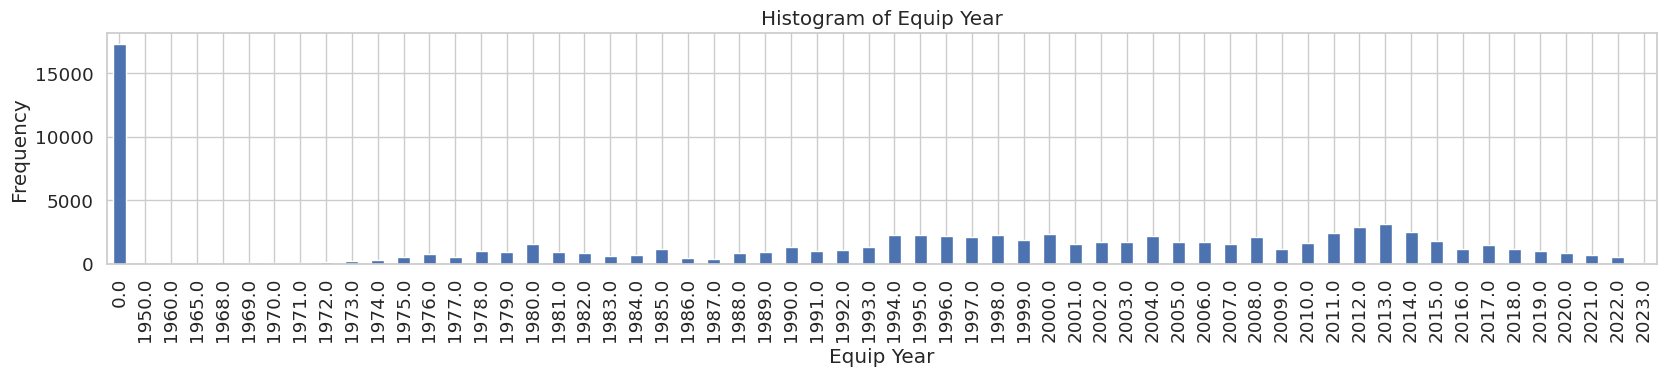

In [55]:
value_counts = claims_premiums_df['Equip Year'].value_counts().sort_index()

plt.figure(figsize = (20, 3))
value_counts.plot(kind='bar')
plt.xlabel('Equip Year')
plt.ylabel('Frequency')
plt.title('Histogram of Equip Year')
plt.show()